# Framework for initialization and hyperparameter scaling with network size.

In [2]:
import torch 
import torch.nn as nn
from torchvision import datasets, transforms
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.MNIST('mnist/', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('mnist/', train=False, download=True, transform=transform)

batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 93776062.86it/s]


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117607469.73it/s]


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26513312.06it/s]


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21672956.51it/s]


Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw



In [5]:
!pip install mup

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for mup: filename=mup-1.0.0-py3-none-any.whl size=23650 sha256=88a66667252e7f039fe6896bae76840b1b77156774be23f71f9f89eb8d9dcc8e
  Stored in directory: /root/.cache/pip/wheels/f4/c8/88/3c23a3d10c50053b6552d2d30aee5b53ba89a47f742420036c
Successfully built mup


In [6]:
import mup
from mup import MuReadout, MuSGD, set_base_shapes, MuAdam

In [7]:
def MuBBI(params, **kwargs):
    return MuAdam(params, impl=BBI, **kwargs)

In [8]:
class Net(nn.Module):
    def __init__(self, channels=16, n_hidden=2):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=channels, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=channels, out_channels=channels*2, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.relu = nn.ReLU()
        self.layers = []
        self.layers += [self.conv1, self.relu, self.pool, self.conv2, self.relu]
        in_chan = channels*2
        if n_hidden > 2:
            for i in range(n_hidden - 2):
                self.conv = nn.Conv2d(in_channels=in_chan, out_channels=in_chan*2, kernel_size=3, padding=1)
                self.layers += [self.conv, self.relu]
                in_chan = in_chan*2
        self.layers += [self.pool]
        self.net = nn.Sequential(*self.layers)
        # self.fc1 = nn.Linear(in_features=in_chan*7*7, out_features=120)
        self.fc2 = MuReadout(in_chan*7*7, 120)
        
    def forward(self, x):
        x = self.net(x)
        x = torch.flatten(x, start_dim=1)
        # x = self.fc1(x)
        x = self.fc2(x)
        return x

In [9]:
criterion = nn.CrossEntropyLoss()

# Train
epochs = 5
n_check = 6
test_loss_SGD = []
test = []
for k in [2, 7]:
    print(f'Run: {k+1} \t# of conv. layers: {2+k}')
    base_model = Net(channels=2, n_hidden=k).to(device)
    delta_model = Net(channels=4, n_hidden=k).to(device)
    model = Net(channels=16, n_hidden=k).to(device)

    set_base_shapes(model, base_model, delta=delta_model)

    for param in model.parameters():
        mup.init.uniform_(param, -0.1, 0.1)

    optimizer = MuSGD(model.parameters(), lr=0.01)

    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()
            loss_tr += loss.item()
    
    # Evaluate
    correct = 0
    total = 0
    loss_tr = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss_SGD.append(loss_tr/len(test_loader))
    test.append(correct/total)

Run: 3 	# of conv. layers: 4
Run: 8 	# of conv. layers: 9


In [10]:
test_loss_SGD, test

([0.10458512741858793, 0.07985932561776536], [0.9683, 0.9745])

In [11]:
criterion = nn.CrossEntropyLoss()

# Train
epochs = 5
n_check = 6
test_loss_Adam = []
test = []
for k in [2, 7]:
    base_model = Net(channels=2, n_hidden=k).to(device)
    delta_model = Net(channels=4, n_hidden=k).to(device)
    model = Net(channels=16, n_hidden=k).to(device)

    set_base_shapes(model, base_model, delta=delta_model)

    for param in model.parameters():
        mup.init.uniform_(param, -0.1, 0.1)

    optimizer = MuAdam(model.parameters(), lr=0.001)

    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward() 
            optimizer.step()
            loss_tr += loss.item()
    
    # Evaluate
    correct = 0
    total = 0
    loss_tr = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss_Adam.append(loss_tr/len(test_loader))
    test.append(correct/total)

In [12]:
test_loss_Adam, test

([0.0669511352238619, 0.026623190363207653], [0.9776, 0.9914])

In [13]:
base_model = Net(channels=2, n_hidden=7).to(device)
delta_model = Net(channels=4, n_hidden=7).to(device)
model = Net(channels=16, n_hidden=7).to(device)

set_base_shapes(model, base_model, delta=delta_model)

for param in model.parameters():
    mup.init.uniform_(param, -0.1, 0.1)

v0 = 1e-6
threshold0 = 100
n_fixed_bounces = 5
threshold = 1000

optimizer = MuBBI(model.parameters(), lr=0.2, deltaEn=1.0, v0=v0, threshold0 = threshold0, threshold = threshold, n_fixed_bounces = n_fixed_bounces)

In [14]:
criterion = nn.CrossEntropyLoss()

# Train
epochs = 5
v0 = 1e-6
threshold0 = 100
n_fixed_bounces = 5
threshold = 1000
n_check = 6
test_loss_BBI = []
test = []
for k in [2, 7]:
    base_model = Net(channels=2, n_hidden=k).to(device)
    delta_model = Net(channels=4, n_hidden=k).to(device)
    model = Net(channels=16, n_hidden=k).to(device)

    set_base_shapes(model, base_model, delta=delta_model)

    for param in model.parameters():
        mup.init.uniform_(param, -0.1, 0.1)

    optimizer = MuBBI(model.parameters(), lr=0.2, deltaEn=1.0, v0=v0, threshold0 = threshold0, threshold = threshold, n_fixed_bounces = n_fixed_bounces)

    for epoch in range(1, epochs+1):
        loss_tr = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            def closure(): return loss 
            optimizer.step(closure)
            loss_tr += loss.item()
    
    # Evaluate
    correct = 0
    total = 0
    loss_tr = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_tr += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        test_loss_BBI.append(loss_tr/len(test_loader))
    test.append(correct/total)

In [15]:
test_loss_BBI, test

([0.09324240137716429, 0.045926685187339805], [0.9796, 0.9871])

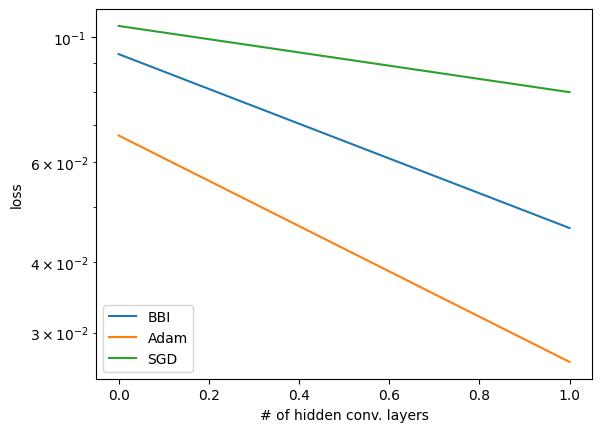

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

t = np.arange(2)

sns.lineplot(y=test_loss_BBI, x=t, label='BBI')
sns.lineplot(y=test_loss_Adam, x=t, label='Adam')
sns.lineplot(y=test_loss_SGD, x=t, label='SGD')
plt.yscale('log')

# plt.title('Comparing performance of different architeture.')
plt.xlabel('# of hidden conv. layers')
plt.ylabel('loss')

plt.legend()
plt.show()

## maximal update parametrization (µP)

## Learning Rate Scaling with Width